In [17]:
import torch
from torch import nn, optim
from torch.utils.data import DataLoader
import torch.nn.functional as F

# for loading MNIST data
from torchvision import transforms, datasets

In [18]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook as tqdm
%matplotlib inline

In [19]:
# if cuda device is available then run model on gpu
if torch.cuda.is_available():
    cuda_flag=True
else:
    cuda_flag=False

### Setting up data loader

In [76]:
batch_size=128

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[1])])

train_loader = torch.utils.data.DataLoader(
                datasets.MNIST('./dataset/', train=True, download=True,transform=transform),
                batch_size=batch_size, shuffle=True)

test_loader = torch.utils.data.DataLoader(
                datasets.MNIST('./dataset/', train=False, download=True, transform=transform),
                 batch_size=batch_size)

In [77]:
x = next(iter(test_loader))


In [78]:
x[0][0][0]

tensor([[-0.5000, -0.5000, -0.5000, -0.5000, -0.5000, -0.5000, -0.5000, -0.5000,
         -0.5000, -0.5000, -0.5000, -0.5000, -0.5000, -0.5000, -0.5000, -0.5000,
         -0.5000, -0.5000, -0.5000, -0.5000, -0.5000, -0.5000, -0.5000, -0.5000,
         -0.5000, -0.5000, -0.5000, -0.5000],
        [-0.5000, -0.5000, -0.5000, -0.5000, -0.5000, -0.5000, -0.5000, -0.5000,
         -0.5000, -0.5000, -0.5000, -0.5000, -0.5000, -0.5000, -0.5000, -0.5000,
         -0.5000, -0.5000, -0.5000, -0.5000, -0.5000, -0.5000, -0.5000, -0.5000,
         -0.5000, -0.5000, -0.5000, -0.5000],
        [-0.5000, -0.5000, -0.5000, -0.5000, -0.5000, -0.5000, -0.5000, -0.5000,
         -0.5000, -0.5000, -0.5000, -0.5000, -0.5000, -0.5000, -0.5000, -0.5000,
         -0.5000, -0.5000, -0.5000, -0.5000, -0.5000, -0.5000, -0.5000, -0.5000,
         -0.5000, -0.5000, -0.5000, -0.5000],
        [-0.5000, -0.5000, -0.5000, -0.5000, -0.5000, -0.5000, -0.5000, -0.5000,
         -0.5000, -0.5000, -0.5000, -0.5000, -0.5000

### Class Definitions for Models
For a Generative Adversarial Network we have a Discriminator and a Generator model. The Generator tries to generate an example which mimics the real data, whereas Discriminator tries to discriminate between real data and the examples gnerated by Generator. Both the models try to fool each other and in this process keep improving.

In [79]:
class Generator(nn.Module):
    def __init__(self, g_input_dim, g_output_dim):
        super(Generator, self).__init__()       
        self.fc1 = nn.Linear(g_input_dim, 256)
        self.fc2 = nn.Linear(self.fc1.out_features, self.fc1.out_features*2)
        self.fc3 = nn.Linear(self.fc2.out_features, self.fc2.out_features*2)
        self.fc4 = nn.Linear(self.fc3.out_features, g_output_dim)
    
    # forward method
    def forward(self, x): 
        x = F.leaky_relu(self.fc1(x), 0.2)
        x = F.leaky_relu(self.fc2(x), 0.2)
        x = F.leaky_relu(self.fc3(x), 0.2)
        return torch.tanh(self.fc4(x))
    
class Discriminator(nn.Module):
    def __init__(self, d_input_dim):
        super(Discriminator, self).__init__()
        self.fc1 = nn.Linear(d_input_dim, 1024)
        self.fc2 = nn.Linear(self.fc1.out_features, self.fc1.out_features//2)
        self.fc3 = nn.Linear(self.fc2.out_features, self.fc2.out_features//2)
        self.fc4 = nn.Linear(self.fc3.out_features, 1)
    
    # forward method
    def forward(self, x):
        x = F.leaky_relu(self.fc1(x), 0.2)
        x = F.dropout(x, 0.3)
        x = F.leaky_relu(self.fc2(x), 0.2)
        x = F.dropout(x, 0.3)
        x = F.leaky_relu(self.fc3(x), 0.2)
        x = F.dropout(x, 0.3)
        return torch.sigmoid(self.fc4(x))

### Training the models

In [80]:
def noise(batch_size):
    n = (torch.randn(batch_size, 100))/100
    return n

In [81]:
def d_train(x):
    dis_train_loss = 0
    # training discriminator on real data
    d_optimizer.zero_grad()

    if cuda_flag:
        x = x.view(len(x),-1).cuda()

    y_pred = D(x)
    loss = crit(y_pred, torch.ones(len(x),1).cuda())
    dis_train_loss+= loss.item()

    loss.backward()
    d_optimizer.step()

    # training discriminator on real data
    d_optimizer.zero_grad()

    x = noise(batch_size)
    if cuda_flag:
        x = x.cuda()

    fake_data = G(x).detach()
    y_pred = D(fake_data)
    loss = crit(y_pred, torch.zeros(batch_size,1).cuda())
    dis_train_loss+= loss.item()

    loss.backward()
    d_optimizer.step()
    
    return dis_train_loss

In [94]:
def g_train(f):
    gen_train_loss=0
    g_optimizer.zero_grad()    
    x = noise(batch_size)
    if cuda_flag:
        x = x.cuda()

    fake_data = G(x)
    y_pred = D(fake_data)
    if (f%100==0):
        print(f,torch.sum(y_pred))
        plt.imshow(G(noise(1).cuda()).detach().cpu().numpy().reshape(28,28)+0.5)
        plt.show()
    loss = crit(y_pred, real_labels)
    gen_train_loss+=loss.item()

    loss.backward()
    g_optimizer.step()
    return gen_train_loss

In [95]:
D = Discriminator(784)
G = Generator(100, 784)

if (cuda_flag):
    D = D.cuda()
    G = G.cuda()

In [96]:
d_optimizer = optim.Adam(D.parameters(), lr=1e-4, weight_decay=1e-4)
g_optimizer = optim.Adam(G.parameters(), lr=1e-4, weight_decay=1e-4)

In [97]:
crit = nn.BCELoss()

In [98]:
epochs = 30
gen_loss = []
dis_loss = []
real_labels = torch.ones(batch_size,1).cuda()
fake_labels = torch.zeros(batch_size,1).cuda()

100 tensor(49.4173, device='cuda:0', grad_fn=<SumBackward0>)


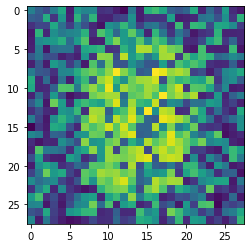


Epoch:0    Discriminator Loss:98.60584843158722   Generator Loss:105.99852389097214


200 tensor(24.3136, device='cuda:0', grad_fn=<SumBackward0>)


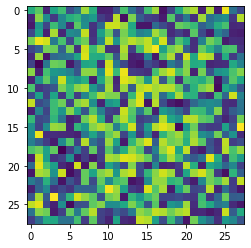

300 tensor(77.0131, device='cuda:0', grad_fn=<SumBackward0>)


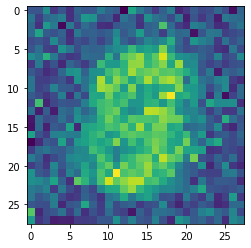


Epoch:1    Discriminator Loss:173.99371972680092   Generator Loss:267.595901504159


400 tensor(35.0715, device='cuda:0', grad_fn=<SumBackward0>)


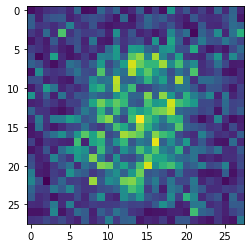


Epoch:2    Discriminator Loss:291.8804532289505   Generator Loss:417.23476155102253


500 tensor(63.4446, device='cuda:0', grad_fn=<SumBackward0>)


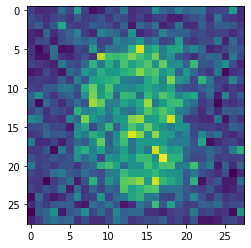

600 tensor(58.7627, device='cuda:0', grad_fn=<SumBackward0>)


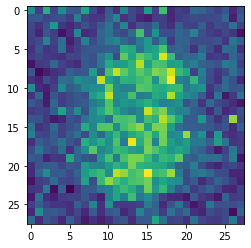


Epoch:3    Discriminator Loss:396.79072701931   Generator Loss:452.8349760323763


700 tensor(67.1603, device='cuda:0', grad_fn=<SumBackward0>)


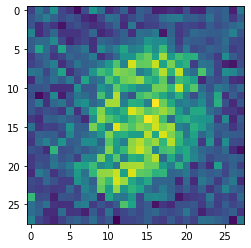


Epoch:4    Discriminator Loss:502.2904087603092   Generator Loss:416.26182958483696


800 tensor(71.1570, device='cuda:0', grad_fn=<SumBackward0>)


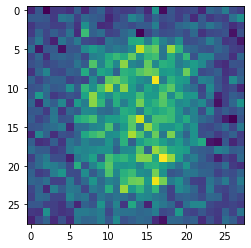

900 tensor(51.4509, device='cuda:0', grad_fn=<SumBackward0>)


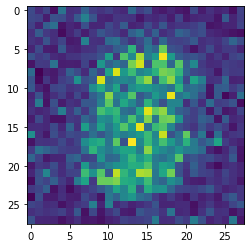


Epoch:5    Discriminator Loss:595.0687039494514   Generator Loss:423.1229864656925


1000 tensor(49.6432, device='cuda:0', grad_fn=<SumBackward0>)


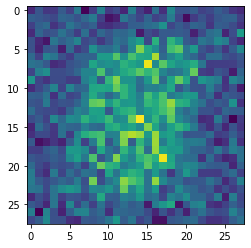

1100 tensor(36.3140, device='cuda:0', grad_fn=<SumBackward0>)


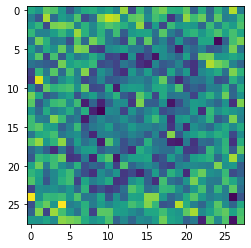


Epoch:6    Discriminator Loss:566.0416647847742   Generator Loss:442.0320821404457


1200 tensor(24.2545, device='cuda:0', grad_fn=<SumBackward0>)


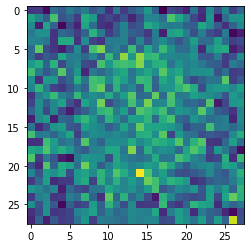


Epoch:7    Discriminator Loss:548.4668494798243   Generator Loss:503.9648724794388


1300 tensor(26.1467, device='cuda:0', grad_fn=<SumBackward0>)


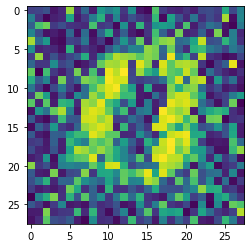

1400 tensor(57.5727, device='cuda:0', grad_fn=<SumBackward0>)


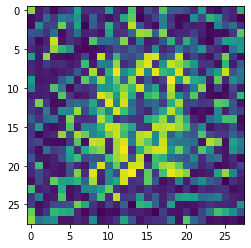


Epoch:8    Discriminator Loss:558.2168802209198   Generator Loss:584.2283109426498


1500 tensor(19.0603, device='cuda:0', grad_fn=<SumBackward0>)


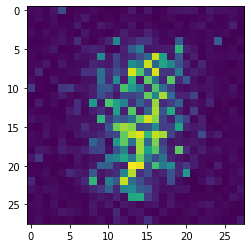


Epoch:9    Discriminator Loss:548.3150810934603   Generator Loss:675.4092745482922


1600 tensor(32.0702, device='cuda:0', grad_fn=<SumBackward0>)


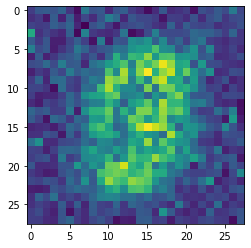

1700 tensor(48.1500, device='cuda:0', grad_fn=<SumBackward0>)


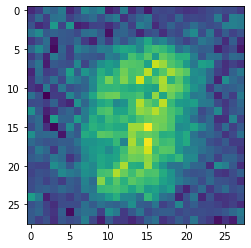


Epoch:10    Discriminator Loss:507.53542836382985   Generator Loss:643.2578610777855


1800 tensor(35.4605, device='cuda:0', grad_fn=<SumBackward0>)


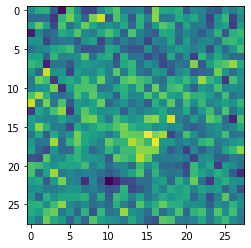


Epoch:11    Discriminator Loss:485.3482122309506   Generator Loss:593.4102583527565


1900 tensor(46.5851, device='cuda:0', grad_fn=<SumBackward0>)


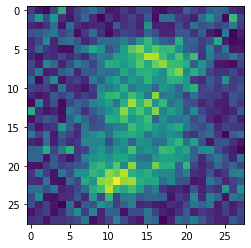

2000 tensor(32.8825, device='cuda:0', grad_fn=<SumBackward0>)


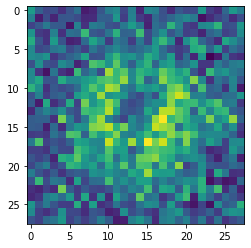


Epoch:12    Discriminator Loss:490.1048140292987   Generator Loss:571.6770213246346


2100 tensor(22.6244, device='cuda:0', grad_fn=<SumBackward0>)


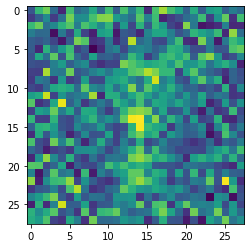

2200 tensor(32.1763, device='cuda:0', grad_fn=<SumBackward0>)


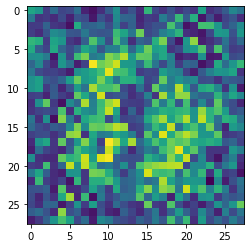


Epoch:13    Discriminator Loss:481.66132617369294   Generator Loss:655.2375491261482


2300 tensor(31.6384, device='cuda:0', grad_fn=<SumBackward0>)


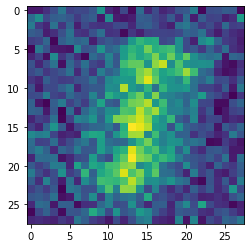


Epoch:14    Discriminator Loss:438.8403218276799   Generator Loss:720.4076070785522


2400 tensor(37.4353, device='cuda:0', grad_fn=<SumBackward0>)


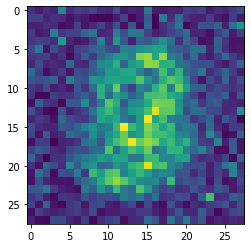

2500 tensor(13.7167, device='cuda:0', grad_fn=<SumBackward0>)


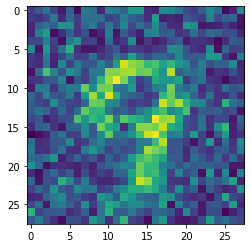


Epoch:15    Discriminator Loss:391.75919493474066   Generator Loss:788.2162981033325


2600 tensor(35.9065, device='cuda:0', grad_fn=<SumBackward0>)


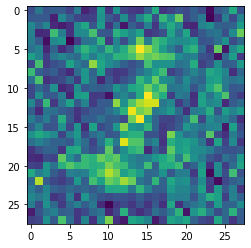


Epoch:16    Discriminator Loss:397.69540653564036   Generator Loss:808.601337313652


2700 tensor(24.0466, device='cuda:0', grad_fn=<SumBackward0>)


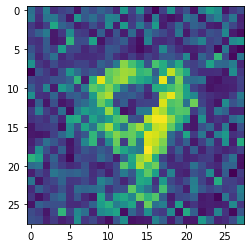

2800 tensor(18.8766, device='cuda:0', grad_fn=<SumBackward0>)


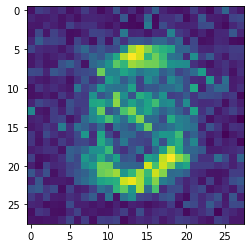


Epoch:17    Discriminator Loss:382.4364605564624   Generator Loss:880.5172123908997


2900 tensor(37.5557, device='cuda:0', grad_fn=<SumBackward0>)


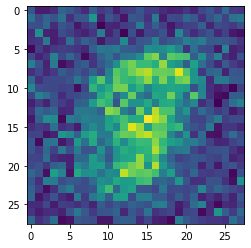

3000 tensor(42.5404, device='cuda:0', grad_fn=<SumBackward0>)


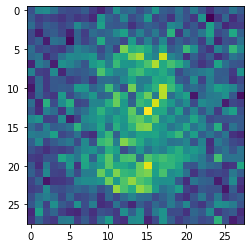


Epoch:18    Discriminator Loss:381.0102166477591   Generator Loss:834.2028721570969


3100 tensor(20.0485, device='cuda:0', grad_fn=<SumBackward0>)


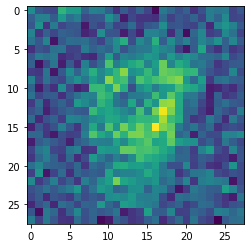


Epoch:19    Discriminator Loss:350.48749386519194   Generator Loss:851.0094728469849


3200 tensor(31.2125, device='cuda:0', grad_fn=<SumBackward0>)


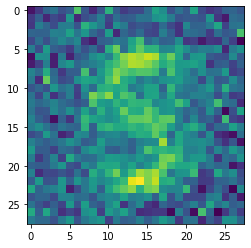

3300 tensor(17.4571, device='cuda:0', grad_fn=<SumBackward0>)


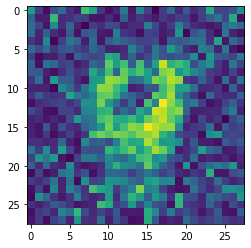


Epoch:20    Discriminator Loss:341.47376906313   Generator Loss:892.3996365070343


3400 tensor(27.0406, device='cuda:0', grad_fn=<SumBackward0>)


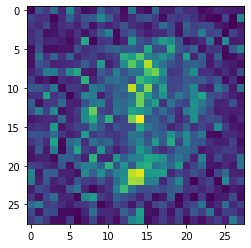


Epoch:21    Discriminator Loss:365.7448558025062   Generator Loss:935.4471120834351


3500 tensor(24.2884, device='cuda:0', grad_fn=<SumBackward0>)


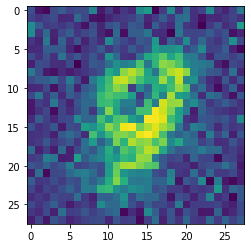

3600 tensor(18.0735, device='cuda:0', grad_fn=<SumBackward0>)


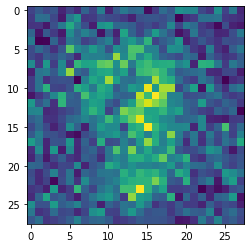


Epoch:22    Discriminator Loss:340.98480095528066   Generator Loss:945.9559640884399


3700 tensor(21.6318, device='cuda:0', grad_fn=<SumBackward0>)


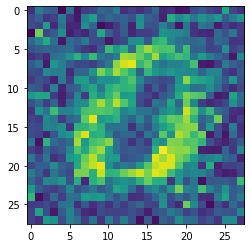


Epoch:23    Discriminator Loss:348.74043080955744   Generator Loss:835.6817623972893


3800 tensor(40.7122, device='cuda:0', grad_fn=<SumBackward0>)


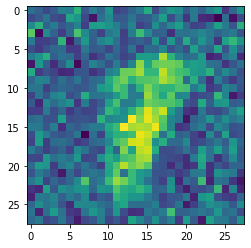

KeyboardInterrupt: 

In [99]:
steps=0
for epoch in range(epochs):
    for x,_ in tqdm(test_loader):
        dis_loss.append(d_train(x))
        for _ in range(2):
            steps+=1
            gen_loss.append(g_train(steps))        
    print("Epoch:{}    Discriminator Loss:{:6}   Generator Loss:{:6}".format(epoch, sum(dis_loss[-len(train_loader):]), 
                                                                             sum(gen_loss[-len(train_loader):])))
        

In [11]:
D(next(iter(train_loader))[0].view(batch_size,-1).cuda())

tensor([[0.4818],
        [0.4793],
        [0.4764],
        [0.4798],
        [0.4682],
        [0.4748],
        [0.4715],
        [0.4706],
        [0.4867],
        [0.4710],
        [0.4751],
        [0.4728],
        [0.4758],
        [0.4754],
        [0.4709],
        [0.4790],
        [0.4705],
        [0.4727],
        [0.4752],
        [0.4697],
        [0.4838],
        [0.4760],
        [0.4738],
        [0.4746],
        [0.4716],
        [0.4737],
        [0.4724],
        [0.4757],
        [0.4800],
        [0.4734],
        [0.4752],
        [0.4771],
        [0.4796],
        [0.4770],
        [0.4827],
        [0.4747],
        [0.4824],
        [0.4750],
        [0.4758],
        [0.4759],
        [0.4745],
        [0.4771],
        [0.4692],
        [0.4795],
        [0.4771],
        [0.4743],
        [0.4774],
        [0.4780],
        [0.4805],
        [0.4823],
        [0.4696],
        [0.4783],
        [0.4779],
        [0.4698],
        [0.4717],
        [0

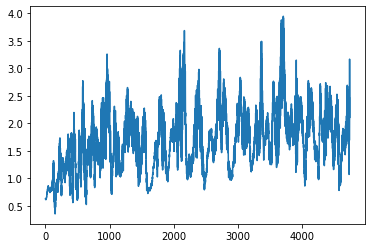

In [92]:
plt.plot(gen_loss)

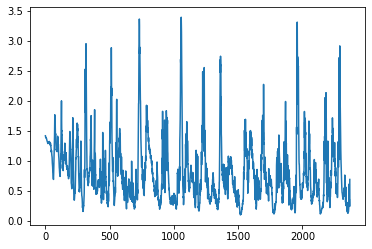

In [93]:
plt.plot(dis_loss)

In [9]:
for _,y in train_loader:
    if (len(y)!=32):
        print (len(y))

In [22]:
noise(1)

tensor([[-0.6525, -0.4085, -0.2954,  0.3163,  0.6415, -0.2602, -0.4483,  0.2193,
          1.4589,  1.1537, -0.0388,  0.6712, -0.4607,  0.6642,  0.5916,  1.4465,
          0.0791,  0.9509,  0.2276, -0.4851, -0.7742,  0.2889, -0.5014,  0.0375,
         -1.0835,  0.6486,  0.7896,  1.0781, -0.9234, -0.7688,  0.2375, -0.0167,
         -1.2113,  0.3556,  1.4682, -0.4573, -0.2857, -0.9577,  0.8438,  0.1603,
          0.5603, -0.0752,  0.4053,  1.1079,  0.6694,  1.1216,  0.2335, -0.3913,
          0.8210, -2.9430,  0.2893,  0.2900, -0.8421, -0.3647,  1.7190, -0.1094,
          0.8612,  0.6292,  1.6335, -0.8800,  0.5247, -0.7327,  1.5874, -0.2182,
         -2.1357,  1.2632,  0.3157,  0.0447,  0.5054, -0.5434, -0.6051,  0.8051,
         -1.1167,  1.2413, -0.9510, -1.7495, -0.5843, -0.5683, -0.1320, -1.2308,
          0.6213,  1.4884, -0.8078,  1.8474,  0.0632,  1.4516,  0.0648,  0.6173,
          0.7416,  0.9637, -1.5547, -1.8906,  1.5526,  0.6478,  1.2367, -2.1178,
          0.7342, -0.7386, -